In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs, unix_timestamp, row_number, udf, sum, avg, round, corr
import matplotlib.pyplot as plt
import folium
from pyspark.sql.window import Window
from pyspark.sql.types import StringType

spark = SparkSession.builder.appName("BikeWeatherAnalysis").getOrCreate()

Matplotlib is building the font cache; this may take a moment.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/03 00:16:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# This dataset has Velib data from '2020-11-26T12:59Z' and '2021-04-09T14:37Z'

velib_df = spark.read.csv('velib.csv', header=None, inferSchema=True) \
    .withColumnRenamed('_c0', 'date') \
    .withColumnRenamed('_c1', 'capacity') \
    .withColumnRenamed('_c2', 'available_mechanical') \
    .withColumnRenamed('_c3', 'available_electrical') \
    .withColumnRenamed('_c4', 'station_name') \
    .withColumnRenamed('_c5', 'station_geo') \
    .withColumnRenamed('_c6', 'operative') 

In [ ]:
velib_df.printSchema()

In [49]:
weather_df = spark.read.csv('weather.csv', header=True, inferSchema=True)

In [50]:
weather_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- temperature_2m (°C): double (nullable = true)
 |-- apparent_temperature (°C): double (nullable = true)
 |-- precipitation (mm): double (nullable = true)
 |-- cloud_cover (%): integer (nullable = true)
 |-- wind_speed_10m (km/h): double (nullable = true)
 |-- is_day (): integer (nullable = true)



In [ ]:
velib_df = velib_df.withColumn(
    "velib_ts", unix_timestamp(col("date"), "yyyy-MM-dd'T'HH:mm'Z'")
)


weather_df = weather_df.withColumn(
    "weather_ts", unix_timestamp(col("time"))
)

In [ ]:
time_window = 3600  # 1 hour in seconds


filtered_joined_df = velib_df.join(
    weather_df,
    (velib_df["velib_ts"] - weather_df["weather_ts"]
     ).between(-time_window, time_window),
    how="inner"
)
filtered_joined_df = filtered_joined_df.withColumn(
    "time_diff", abs(col("velib_ts") - col("weather_ts"))
)

In [ ]:
# Define a window partitioned by `velib_ts`, ordered by `time_diff` (ascending)
window_spec = Window.partitionBy(
    "velib_ts", "station_name").orderBy(col("time_diff"))

# Assign a ranking based on the smallest `time_diff`
closest_weather_df = filtered_joined_df.withColumn("rank", row_number().over(window_spec)) \
                                       .filter(col("rank") == 1) \
                                       .drop("rank", "time_diff", 'velib_ts', 'time', 'weather_ts')


# closest_weather_df.show()

In [ ]:
# print unique coordinates
unique_locations = closest_weather_df.select(
    'station_geo').distinct().collect()
unique_locations = [tuple(map(float, loc[0].split(",")))
                    for loc in unique_locations]

unique_locations

In [ ]:
import googlemaps

gmaps = googlemaps.Client(key="XXXXXXXXXXXX")

def get_arrondissement(lat, lon, cache={}):
    key = (lat, lon)
    if key in cache:
        return cache[key]

    result = gmaps.reverse_geocode((lat, lon))
    postal_code = None
    for match in result:
        for component in match['address_components']:
            if 'postal_code' in component['types']:
                postal_code = component['long_name']
                if not postal_code.startswith('75'):
                    postal_code = None
                break

    if postal_code is not None:
        postal_code = postal_code[-2:]

    cache[key] = postal_code
    return postal_code


In [ ]:
import tqdm
arrondissement_map = {loc: get_arrondissement(
    *loc) for loc in tqdm.tqdm(unique_locations)}

In [ ]:
broadcast_map = spark.sparkContext.broadcast(arrondissement_map)

@udf(StringType())
def get_arrondissement_udf(station_geo):
    loc = tuple(map(float, station_geo.split(",")))
    return broadcast_map.value.get(loc, None)

In [ ]:
closest_weather_df = closest_weather_df.withColumn(
    "arrondissement", get_arrondissement_udf(col("station_geo")))

In [ ]:
# filter out rows with no arrondissement
closest_weather_df = closest_weather_df.filter(
    col("arrondissement").isNotNull())


In [2]:
# closest_weather_df.write.csv('clean.csv', header=True)

# load the data
clean_df = spark.read.csv('clean.csv', header=True, inferSchema=True)

In [3]:
clean_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- capacity: integer (nullable = true)
 |-- available_mechanical: integer (nullable = true)
 |-- available_electrical: integer (nullable = true)
 |-- station_name: string (nullable = true)
 |-- station_geo: string (nullable = true)
 |-- operative: boolean (nullable = true)
 |-- temperature_2m (°C): double (nullable = true)
 |-- apparent_temperature (°C): double (nullable = true)
 |-- precipitation (mm): double (nullable = true)
 |-- cloud_cover (%): integer (nullable = true)
 |-- wind_speed_10m (km/h): double (nullable = true)
 |-- is_day (): integer (nullable = true)
 |-- arrondissement: integer (nullable = true)



In [4]:
station_avg_capacity = clean_df.groupBy("station_name").agg(
    avg("capacity").alias("avg_capacity"))

# Join back with arrondissement mapping
df_with_arrondissement = clean_df.select(
    "station_name", "arrondissement").distinct()
station_avg_capacity = station_avg_capacity.join(
    df_with_arrondissement, "station_name", "left")

# Compute the sum of average capacities per arrondissement
arrondissement_capacity = station_avg_capacity.groupBy("arrondissement") \
    .agg(sum("avg_capacity").alias("total_avg_capacity"))

# round the capacity to nearest integer and sort by total_avg_capacity
arrondissement_capacity = arrondissement_capacity.withColumn(
    "total_avg_capacity", col("total_avg_capacity").cast("int")) \
    .orderBy("total_avg_capacity", ascending=False)

arrondissement_capacity.show()

+--------------+------------------+
|arrondissement|total_avg_capacity|
+--------------+------------------+
|            15|              3361|
|            12|              2630|
|            13|              2298|
|            11|              2252|
|            16|              2152|
|            17|              2131|
|            20|              1918|
|            19|              1860|
|            18|              1856|
|            14|              1849|
|             8|              1617|
|            10|              1573|
|             5|              1204|
|             7|              1135|
|             9|              1103|
|             6|              1003|
|             2|               742|
|             1|               712|
|             4|               706|
|             3|               390|
+--------------+------------------+



In [5]:
# Finally, for every unique time, group all the stations by arrondissement together, take the sum of all the available bikes in the arrondissement and divide by the total capacity of each arrondissement. I want to have a fraction capacity of the use of arrondissement

capacity_df = clean_df.groupBy("arrondissement", "date").agg(
    sum("available_mechanical").alias("total_available_mechanical"),
    sum("available_electrical").alias("total_available_electrical"),
    round(avg("temperature_2m (°C)"), 0).alias("avg_temperature"),
    round(avg("apparent_temperature (°C)"), 0).alias("avg_apparent_temperature"),
    round(avg("precipitation (mm)"), 1).alias("avg_precipitation"),
    round(avg("cloud_cover (%)"), 0).alias("avg_cloud_cover"),
    round(avg("wind_speed_10m (km/h)"), 1).alias("avg_wind_speed"),
    round(avg("is_day ()"), 0).alias("avg_is_day")
).join(
    arrondissement_capacity, "arrondissement"
).withColumn(
    "total_available", col("total_available_mechanical") + col("total_available_electrical")
).withColumn(
    "capacity_ratio", col("total_available") / col("total_avg_capacity")
).orderBy(
    "date", "arrondissement"
)

In [8]:
# write to processed.csv
# capacity_df.write.csv('processed.csv', header=True)

# load the data
df = spark.read.csv('processed.csv', header=True, inferSchema=True)

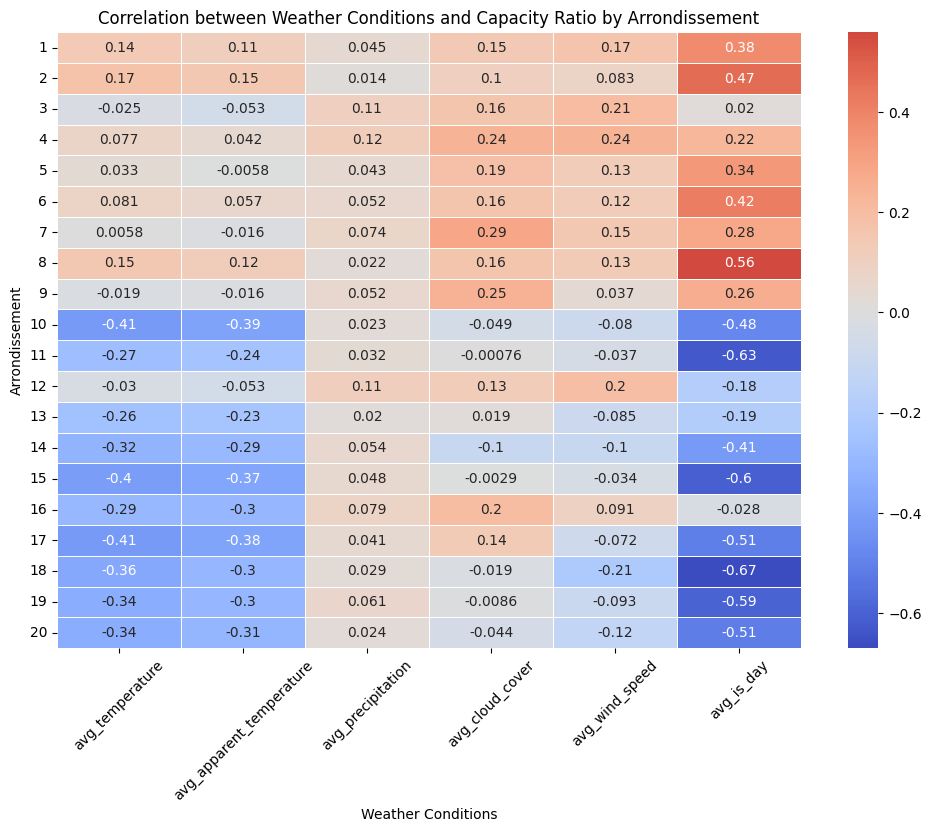

In [18]:
import pandas as pd
import seaborn as sns

weather_params = ["avg_temperature", "avg_apparent_temperature", "avg_precipitation",
                  "avg_cloud_cover", "avg_wind_speed", "avg_is_day"]


arrondissements = df.select(
    "arrondissement").distinct().rdd.flatMap(lambda x: x).collect()

# Dictionary to store correlations per arrondissement
arrondissement_correlations = {}

for arr in arrondissements:
    # Filter data for the current arrondissement
    arr_df = df.filter(df.arrondissement == arr)

    # Compute correlations for all weather parameters
    correlations = {param: arr_df.select(corr(param, "capacity_ratio")).collect()[
        0][0] for param in weather_params}

    # Store results
    arrondissement_correlations[arr] = correlations

# Convert to Pandas DataFrame for visualization
correlation_df = pd.DataFrame.from_dict(
    arrondissement_correlations, orient='index').sort_index()

# Plot heatmap
plt.figure(figsize=(12, 8), facecolor='none')
sns.heatmap(correlation_df, annot=True,
            cmap="coolwarm", center=0, linewidths=0.5)
plt.xlabel("Weather Conditions")
plt.ylabel("Arrondissement")
plt.title(
    "Correlation between Weather Conditions and Capacity Ratio by Arrondissement")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.savefig('heatmap.png',  transparent=True, dpi=300)
plt.show()

In [25]:
# geolocation of every arrondissement
arr_loc = {
    "1": (48.862563, 2.336443),
    "2": (48.867418, 2.344898),
    "3": (48.862872, 2.360001),
    "4": (48.854341, 2.357630),
    "5": (48.845392, 2.350465),
    "6": (48.849919, 2.332344),
    "7": (48.856479, 2.321956),
    "8": (48.872721, 2.312554),
    "9": (48.877459, 2.337454),
    "10": (48.876019, 2.361582),
    "11": (48.859961, 2.378985),
    "12": (48.841370, 2.390821),
    "13": (48.832397, 2.355583),
    "14": (48.833510, 2.326583),
    "15": (48.841430, 2.293363),
    "16": (48.863788, 2.276732),
    "17": (48.883348, 2.323736),
    "18": (48.892569, 2.348161),
    "19": (48.887337, 2.384773),
    "20": (48.863461, 2.401188)
}

In [38]:
# filter for the date that is between 3

vdf = df.filter(col('date') == '2020-11-26T12:59Z').toPandas()
# df = velib_df.filter(col('date') == '2020-11-27T23:46Z').toPandas()

In [43]:
# get records velib on 2020-11-26T12:59Z

paris_map = folium.Map(location=[48.8566, 2.3522], zoom_start=12)


for _, record in vdf.iterrows():
    lon, lat = arr_loc[str(record['arrondissement'])]
    usage = record['capacity_ratio']
    if usage < 0.2:
        color = 'green'
    elif usage < 0.6:
        color = 'orange'
    else:
        color = 'red'

    folium.CircleMarker(
        location=[float(lon), float(lat)],
        radius=12,  # Small radius for a dot
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=1,  # Make it fully visible
        weight=0  # Remove border
    ).add_to(paris_map)

paris_map.save('paris.html')